In [103]:
import pandas as pd
import numpy as np
import datetime
from collections import Counter

#api
import praw
import requests
from fake_useragent import UserAgent 
import time


#pre-processing
# import nltk 
from nltk.util import ngrams
from nltk.corpus import stopwords #wordnet
# from nltk.stem import WordNetLemmatizer
# from nltk.tree import Tree
# from nltk.stem.porter import *
# from nltk.tokenize import MWETokenizer 
# from nltk import word_tokenize, pos_tag  #ne_chunk
# import spacy
# from spacy import displacy
# import en_core_web_sm
# import re
from NLP_functions import clean_str, pos_only

#EDA
from NLP_functions import get_top_n_words

#topic modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from NLP_functions import display_topics, prob_df, topic_matrix
# import genism
# from gensim.models import Word2Vec, KeyedVectors, LdaMulticore
# from gensim import corpora, models, similarities, matutils

#sentiment analysis
from NLP_functions import get_sentiments


#plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

Intialize Reddit API

In [2]:
reddit = praw.Reddit(client_id='oCxykEUclueAuA', client_secret='M8wVQw3nFxMsXHLGxurnTtkN-Mdvtg', user_agent='Crypto')

Version 7.0.0 of praw is outdated. Version 7.2.0 was released 21 hours ago.


#### Get top posts of all time

In [3]:
posts = []
ml_subreddit = reddit.subreddit('Cryptocurrency')

#loop through top 1000 posts of all time, get data in list and append to dataframe as new row
for post in list(ml_subreddit.top('all', limit=1000)):
    date = datetime.datetime.utcfromtimestamp(post.created_utc)
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, date])
    
posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'date'])
print(posts.info())

                                                 title  score      id  \
0    Elon Musk reminds me of a rich billionaire who...  39520  lce6zm   
1    CryptoNick is deleting all of his BitConnect v...  26496  7r0ftz   
2    Reminder: Robinhood blocked several stocks fro...  26360  lfrslo   
3    I will tell you exactly what is going on here,...  20140  7vga1y   
4    Robinhood is launching a Crypto Trading app to...  19965  7sx5ze   
..                                                 ...    ...     ...   
926                                        Every time.   1503  ldv9ea   
927         I'm something of a serious investor myself   1489  lo7joj   
928                    Are we moving too fast or what?   1477  lo2pa8   
929                               We're going camping!   1475  lnwpd3   
930  Not another fairy-tale ending - a word of warn...   1428  lfed9k   

          subreddit                                                url  \
0    CryptoCurrency  https://www.reddit.com/r/Cry

#### Get open day prices for BTC, ETH, DOGE, NANO, and XRB based on date of post

In [112]:
#create random user agent and get key for crypto price api
ua = UserAgent()
headers = {'user-agent': ua.random}
key = cryptocompare.cryptocompare._set_api_key_parameter('893488b8793438da44ad6d1e1093de1659841ad589583cf3f376dc468ffce72c')

In [114]:
cryptos = ['BTC', 'ETH', 'XRP','NANO', 'DOGE']

#loop through cryptocurrencies to get prices for 
for c in cryptos:
    l = []
    
    #loop through all posts to get timestamp, request price for cryptocurrecny based on timestamp and in usd
    for index, row in posts.iterrows():
        timestamp = (posts.loc[index,'date']).timestamp()
        url = f'https://min-api.cryptocompare.com/data/v2/histoday?fsym={c}&tsym=USD&limit=1&toTs={timestamp}'
        url += key
        response = requests.get(url, headers=headers)  
        data = response.json()['Data']['Data']
        
        #append open day price to list
        l.append(data[1]['open'])
        
        if index%25 == 0:
            time.sleep(0.5) #pause every 25 loops
            
        #change user agent, chosen randomly every 50 loops
        if index%50 == 0:
            headers = {'user-agent': ua.random}
    
    #append all prices to new column   
    posts[c] = l

                                                 title  score      id  \
0    Elon Musk reminds me of a rich billionaire who...  39520  lce6zm   
1    CryptoNick is deleting all of his BitConnect v...  26496  7r0ftz   
2    Reminder: Robinhood blocked several stocks fro...  26360  lfrslo   
3    I will tell you exactly what is going on here,...  20140  7vga1y   
4    Robinhood is launching a Crypto Trading app to...  19965  7sx5ze   
..                                                 ...    ...     ...   
926                                        Every time.   1503  ldv9ea   
927         I'm something of a serious investor myself   1489  lo7joj   
928                    Are we moving too fast or what?   1477  lo2pa8   
929                               We're going camping!   1475  lnwpd3   
930  Not another fairy-tale ending - a word of warn...   1428  lfed9k   

          subreddit                                                url  \
0    CryptoCurrency  https://www.reddit.com/r/Cry

In [116]:
posts.info()
#save as pickle, cryptocompare API has limited requests
posts.to_pickle('../Data/posts_price_df.pkl')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931 entries, 0 to 930
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         931 non-null    object        
 1   score         931 non-null    int64         
 2   id            931 non-null    object        
 3   subreddit     931 non-null    object        
 4   url           931 non-null    object        
 5   num_comments  931 non-null    int64         
 6   body          931 non-null    object        
 7   date          931 non-null    datetime64[ns]
 8   BTC           931 non-null    float64       
 9   ETH           931 non-null    float64       
 10  XRP           931 non-null    float64       
 11  NANO          931 non-null    float64       
 12  DOGE          931 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(5)
memory usage: 94.7+ KB


#### Get top coments from each top post

In [117]:
all_top_comments = []
#loop through all posts to get top 20 comments from each post, append date and crypto prices
for index, row in posts.iterrows():

    try: #check that post actually exists or hasnt been deleted
        submission = reddit.submission(id=row['id'])
        submission.comments.replace_more(limit=0)
        comments=list([(comment.body) for comment in submission.comments.list()])
        for x in comments[:20]:
            #check that comment hasnt been deleted or is not a reddit bot/moderator
            if x != '[deleted]' and 'Some Important Reminders' not in x and 'moderator' not in x: 
                all_top_comments.append([x,row[7], row[8], row[9], row[10], row[11], row[12]])

    except:
        comments=None
all_top_comments = pd.DataFrame(all_top_comments,columns=['comment', 'date', 'BTC', 'ETH', 'XRP', 'NANO', 'DOGE'])

                                                 comment                date  \
0      If your life savings hinges on a Tweet from a ... 2021-02-04 12:02:16   
1      I seriously don’t understand the obsession wit... 2021-02-04 12:02:16   
2      Tbh u can't place all the blame on Elon tho, t... 2021-02-04 12:02:16   
3      seriously, there's so much more relevant peopl... 2021-02-04 12:02:16   
4      If I'm Elon, I put hundreds of millions into D... 2021-02-04 12:02:16   
...                                                  ...                 ...   
17776  You have a gambling addiction. Some people are... 2021-02-08 15:38:18   
17777  Thanks for your cautionary tale, it's good at ... 2021-02-08 15:38:18   
17778  Sorry to hear and a good lesson for everyone.\... 2021-02-08 15:38:18   
17779  good lessons, thank you for sharing\n\ndont ch... 2021-02-08 15:38:18   
17780  Man sending you a hug. so many of us were brou... 2021-02-08 15:38:18   

            BTC      ETH     XRP   NANO

## Cleaning

In [118]:
all_top_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17781 entries, 0 to 17780
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   comment  17781 non-null  object        
 1   date     17781 non-null  datetime64[ns]
 2   BTC      17781 non-null  float64       
 3   ETH      17781 non-null  float64       
 4   XRP      17781 non-null  float64       
 5   NANO     17781 non-null  float64       
 6   DOGE     17781 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 972.5+ KB


Add stop words

In [547]:
stop = stopwords.words('english')
stop = [w.replace("'", "") for w in stop] #remove apostrophes in stop words

stop = stop + ['moderator', 'subreddit', 'reddit' , 'question', 'concern', 'please', 'contact', 'im', 
        'people', 'gon', 'seems', 'something', 'year', 'like', 'mod', 'wa', 'thread', 'crypto', 'get',
        'see', 'deleted', 'ha', 'use', 'think', 'cryptocurrency', 'thing', 'one', 'even', 'want', 'need',
        'time', 'also', 'got', 'post', 'thats', 'probably', 'u', 'every', 'next', 'reason', 'na', 'give', 'lol',
        'everything', 'know', 'community', 'today', 'come', 'anyone', 'actually', 'removed', 'wtf', 'immage',
        'really', 'nice', 'man', 'work', 'day', 'way', 'would', 'could', 'said', 'submission', 'news', 'nice',
        'enjoy', 'find', 'work', 'job', 'flaired', 'inaccurately', 'click', 'action', 'performed', 'automatically',
        'ive', 'seen', 'sense', 'month', 'pretty', 'much', 'week', 'money', 'coin', 'market', 'right', 'let',
         'someone', 'guy', 'price', 'lot', 'transaction', 'feel', 'list', 'wow', 'well', 'go', 'take', 'thank',
        'something', 'shit', 'fuck', 'look', 'still', 'value', 'back', 'make', 'say', 'sure', 'new', 'happen',
        'buy', 'sell', 'word', 'start', 'trade', 'made', 'implement', 'gif', 'watch', 'worth', 'bought', 'sold',
        'total', 'idea', 'good', 'upvote', 'cant', 'never', 'love', 'oh', 'sub', 'repost', 'great', 'awesome',
        'best', 'quality', 'hope', 'big', 'discuss', 'project', 'believe', 'mean', 'virtual', 'trader',
        'user', 'payment', 'pay', 'try', 'many', 'bad', 'company', 'world', 'invest', 'stock', 'may', 'put',
        'first',  'point', 'already', 'everyon',  'ask',  'around', 'anoth', 'run', 'person'

            'keep', 'end', 'read', 'lose', 'gain', 'alway', 'understand', 'interest',  'last',
          'profit', 'life', 'edit', 'better', 'research', 'dollar', 'adopt',  'without',
         'amount', 'id', 'site',  'million',  'differ', 'help', 'tell', 'investor', 'sinc', 'went', 
         'decid',  'littl',  'inform', 'real', 'talk', 'noth', 'move', 'learn', 'small', 'chang', 
         'stop', 'compani', 'current', 'two', 'free', 'live', 'case',  'term', 
         'ga', 'send', 'card',  'check', 'game',  'full', 'cost',  'problem', 'transfer', 
         'top',  'platform', 'program', 'app', 'process', 'chain', 'issu', 
         'distribut', 'far', 'smart',  'gener', 'anyth', 'correct', 'system', 'huge', 'exist', 'ever', 
         'instead', 'advantag', 'easi',  'els', 'exampl', 'larg', 'creat', 'though', 'format', 
         'vote', 'either',   'support', 'tax', 'entir', 'cryptocurr', 'enough', 'might',
         'theyr', 'care', 'link',  'product', 'mayb', 'video', 'le', 'almost', 'posit', 
         'simpli', 'state', 'done', 'hard',  'internet', 'allow',  'complet', 'least', 'ill', 'fact', 
         'thought', 'stake', 'team', 'design', 'provid', 'stori', 'part', 'show', 'place', 'becom', 'data',
         'busi', 'articl', 'set', 'stuff',  'turn', 'howev', 'follow',  'call', 'possibl',
          'transact', 'order', 'block', 'agre', 'tech', 'ago', 'medium', 
          'respons',  'lost', 'low', 'option',  'past', 'yet',  'wrong', 'true',  
         'averag', 'must', 'number', 'rule', 'ye', 'hey', 'account', 'play', 'comment', 'major', 
         'away', 'hype', 'hous', 'save', 'activ', 'portfolio', 'rich', 'final', 'share', 'ignor', 'cours', 'name', 
         'expect', 'friend', 'economi', 'hand', 'extrem', 'mind', 'eventu', 'saw', 'side', 'claim', 'rather',
         'higher', 'liter', 'liquid', 'base', 'group', 'hear', 'control',  'push', 'due', 
         'kind',  'critic', 'whole', 'public',   'build', 'concept', 'specif',  'left', 
                
         'basic', 'releas',  'plan', 'abil', 'absolut',  'hour',  'add',  
         'loss', 'miss', 'easili', 'manag', 'potenti',  'guess',  'spend', 
         'whatev',  'sort',  'requir', 'standard', 'includ',  
         'rememb', 'bring', 'book', 'nobodi', 'longer', 'statement', 'act', 
         'opinion', 'belief', 'listen', 'rais', 'offer', 'solut', 'perspect', 
         'form', 'speak', 'wealth', 'found', 'strongli', 'heard', 'figur',  'answer', 
         'spent', 'accept', 'compar', 'reach',  'electr', 'miner',  'hit',  'replac',
         'stay', 'purchas',   'consid', 'reach',  'soon', 
         'imagin', 'per', 'renew',  'defy', 'built', 'attempt', 'earn', 'withdraw', 'effect', 'step', 
          'store', 'open', 'ad',  'singl', 'scale', 'zero', 'calcul', 
         'stabl',  'holder', 'fast', 'hit', 'plu', 'realiz', 'took',  'minut',  
          'return', 'chanc',  'digit', 'actual',  'billion', 
          'limit',  'old', 'seem', 'late', 'massiv', 'drive', 'wouldv',
               
         'coupl', 'strategi', 'earli', 'experi',  'happi', 'half',   'suppli', 'bigger', 
         'sustain',  'later', 'break', 'key', 'amaz',  'rel',  
         'comparison', 'meant', 'ride', 'caus', 'leav', 'told', 'note', 'decemb', 'crazi', 'exactli', 'consum', 
         'deal', 'sound', 'produc', 'serious', 'anyway', 'season',  'matter', 'becam',  
         'sever', 'recov', 'obvious', 'chart', 'sit', 'assum', 'win', 'lower', 'came',  
         'updat', 'websit', 'stupid',  'cool',  'access', 'moment', 'summari', 'fun', 
          'institut', 'forget', 'largest',  'estim', 'continu', 'biggest', 'lend', 
         'convert', 'multipl',  'settlement', 'simpl',  'tradit', 
         'report', 'proof', 'carri', 'similar', 'th', 'buck',  'begin', 'natur', 'wish', 'alon',  'sleep',
         'tangibl', 'perform', 'fail', 'popular', 'bot',
        'futur', 'high', 'rise', 'wait', 'beyond', 'financi', 'record', 'develop', 'effort', 'deposit', 'autom', 
        'monetari', 'force', 'impact','person', 'technic', 'contract', 'sourc', 'fair', 'subscrib','polit', 'softwar',
        'relat', 'captur', 'histori', 'practic', 'page','august', 'benefit', 'perhap', 'fan', 'neither', 'hater', 
        'hate', 'bullshit', 'clearli', 'straw', 'instant', 'custom', 'paid','volum', 'merchant', 'connect', 
               'network', 'valid', 'offic', 'resourc', 'announc', 'level', 'progress', 'plenti', 'ahead', 'success',
        'chief', 'address', 'industri', 'accus', 'necessarili', 'competitor', 'whose', 'determin', 'blockchain',
               'keep', 'funny', 'congratul', 'advic', 'weekend', 'reduc', 'verifi', 'wallet', 'toxic', 'emotion',
              'emote', 'remote', 'hold', 'currencies', 'eo', 'solv', 'emot', 'ration', 'node', 'usd',
              'volkswagen', 'tri']

stop = set(stop)

#dictionary for words/acronyms to replace
replace_values = {'btc': 'bitcoin', 
               'dogecoin': 'doge', 
               'bitcoin cash': 'bch', 
               'ethereum': 'eth', 
               'ripple': 'xrp'}

# Init Lemmatizer and stemmer
# lemmatizer = nltk.stem.WordNetLemmatizer()
# stemmer = PorterStemmer()

In [552]:
# def clean_str(comment, stop, replace):
#     '''
#     clean comment string, removing numbers, punctuation, non alphabetical words, replacing words,
#     stop words, and changing to lowercase, 
#     lemmatizing and stemming
    
#     input: 
#     comment = comment to be cleaned,
#     stop = stopwords,
#     replace = dictionary of words to replace
    
#     output: cleaned string
#     '''

#     s = str(comment.lower()) #lowercase
        
#     s = re.sub(r'\([^)]*\)', '', s) #remove links
        
#     #only alphabetical letters
#     NON_ASCII = re.compile(r'[^a-z0-1\s]')
#     s = NON_ASCII.sub(r'', s)
    
#     s = re.sub(r'[0-9]+', '', s) #remove numbers
        
#     #replace acronyms/names 
#     for key, value in replace.items():
#         s = s.replace(key, value) 
  
#     s_token = word_tokenize(s) #tokenize
    
#     s_token = [w.strip() for w in s_token] #remove spaces
    
#     s_token = [w for w in s_token if w not in stop] #remove stop words
        
#     s_token_lemm = [lemmatizer.lemmatize(w) for w in s_token] #Lemmatize
    
#     s_token_lemm_stem = [stemmer.stem(w) for w in s_token_lemm] #stem
        
#     s_token_lemm_stem = [w for w in s_token_lemm_stem if w not in stop] #remove stop words
    
#     s_lemm_stem = " ".join(s_token_lemm_stem) #join back into one string
    
#     return s_lemm_stem

In [553]:
top_comments = all_top_comments.copy()
top_comments['cleaned_comments'] = top_comments.apply (lambda x: clean_str(x['comment'], stop, replace_values), axis=1)
top_comments.head()

,comment,date,BTC,ETH,XRP,NANO,DOGE,cleaned_comments
0,If your life savings hinges on a Tweet from a ...,2021-02-04 12:02:16,37677.34,1667.22,0.3977,3.62,0.03735,hing tweet billionair
1,I seriously don’t understand the obsession wit...,2021-02-04 12:02:16,37677.34,1667.22,0.3977,3.62,0.03735,obsess elon musk space signific tweet rekt bor...
2,"Tbh u can't place all the blame on Elon tho, t...",2021-02-04 12:02:16,37677.34,1667.22,0.3977,3.62,0.03735,tbh blame elon tho yolo doge dumb af yolo twee...
3,"seriously, there's so much more relevant peopl...",2021-02-04 12:02:16,37677.34,1667.22,0.3977,3.62,0.03735,relev cryptodltfintech obsess fascin idol norm...
4,"If I'm Elon, I put hundreds of millions into D...",2021-02-04 12:02:16,37677.34,1667.22,0.3977,3.62,0.03735,elon hundr doge dip tweet doge pull shock


Named find all nouns, verbs, and adjectives in cleaned comments

In [554]:
# def pos_only(row):
#     s = row['cleaned_comments']
    
#     s_token = word_tokenize(s)  # tokenize words
    
#     s_pos = nltk.pos_tag(s_token)
    
#     pos = []
#     for x in s_pos:
#         if x[1] == 'NN' or x[1] == 'VB' or x[1] == 'JJ':
#             pos.append(x[0])
    
#     return ' '.join([word for word in pos])

In [555]:
top_comments['nouns_verbs_adj'] = top_comments.apply (lambda row: pos_only(row), axis=1)
top_comments.head()

### EDA of Comments

Explore top words with frequencies and word cloud

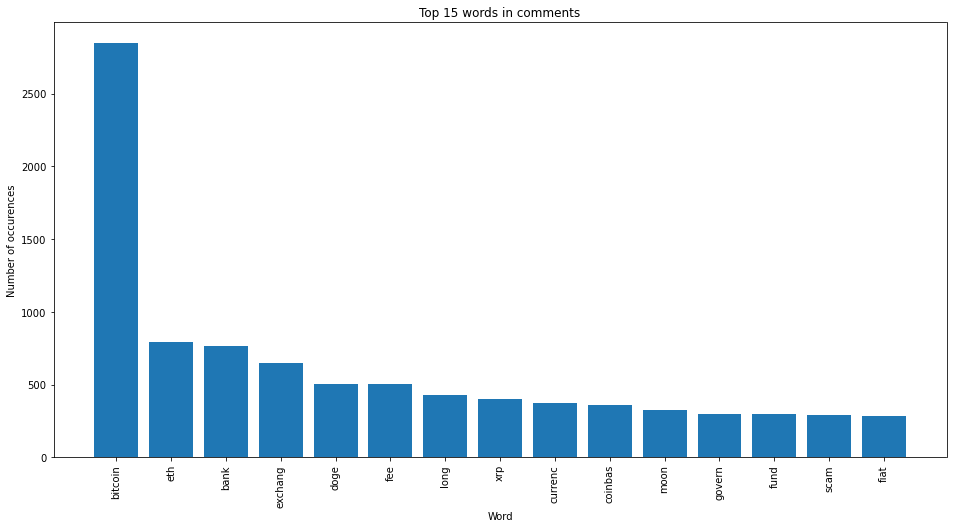

In [568]:
# def get_top_n_words(corpus, stop, n=10):
#     vec = CountVectorizer(stop_words=stop).fit(corpus)
#     bag_of_words = vec.transform(corpus)
#     sum_words = bag_of_words.sum(axis=0) 
#     words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
#     words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#     return words_freq[:n]

words = []
word_values = []
for i,j in get_top_n_words(top_comments['cleaned_comments'], stop, 15):
    words.append(i)
    word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 15 words in comments');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

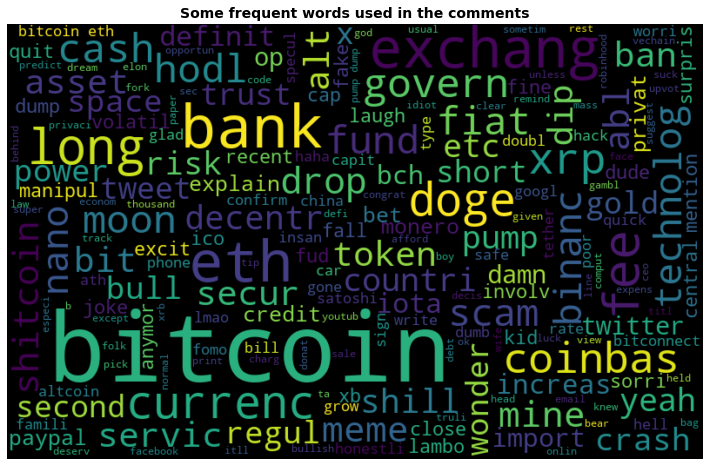

In [559]:
all_words = ' '.join([word for word in top_comments['cleaned_comments']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the comments", weight='bold', fontsize=14)
plt.show()

Explore most frequent nouns, verbs, and adjectives

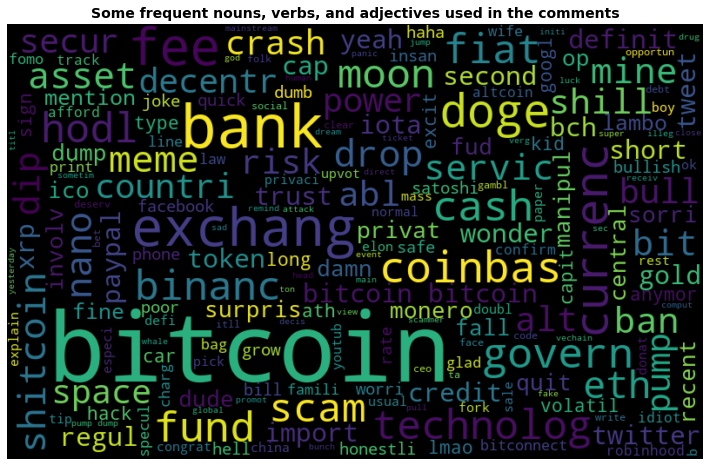

In [516]:
all_nouns = ' '.join([word for word in top_comments['nouns_verbs_adj']])
all_nouns
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_nouns)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent nouns, verbs, and adjectives used in the comments", weight='bold', fontsize=14)
plt.show()

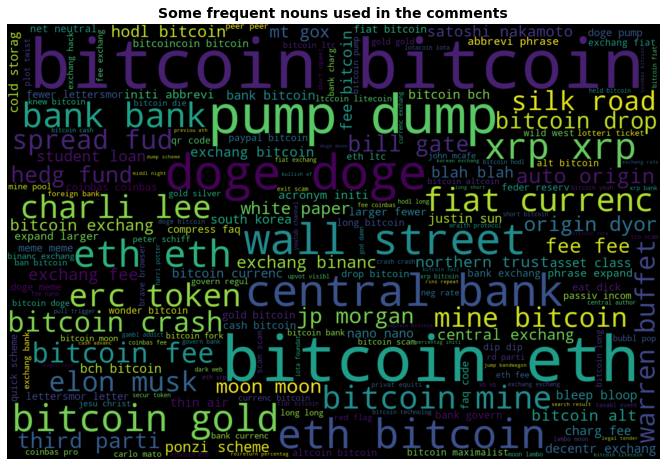

In [570]:
# def find_top_bigrams(all_words, corpus):
# #     nltk_tokens = nltk.word_tokenize(all_words)  
#     bigrams_list = list(nltk.bigrams(corpus))

#     dictionary2 = [' '.join(tup) for tup in bigrams_list]

#     #Using count vectoriser to view the frequency of bigrams
#     vectorizer = CountVectorizer(ngram_range=(2, 2))
#     bag_of_words = vectorizer.fit_transform(dictionary2)
#     vectorizer.vocabulary_
#     sum_words = bag_of_words.sum(axis=0) 
#     words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
#     words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#     return dict(words_freq)

#get dictionary of top bigrams and frequencies
bigrams_freq = find_top_bigrams(all_words, top_comments['cleaned_comments'])   

#Generating wordcloud
WC_height = 1000
WC_width = 1500
WC_max_words = 200
wordCloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width)
wordCloud.generate_from_frequencies(bigrams_freq)
plt.figure(figsize=(15, 8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent nouns used in the comments", weight='bold', fontsize=14)
plt.show()

# Topic Modeling

In [579]:
comments = list(top_comments['cleaned_comments'])

topics = 9
topic_words = 10
topic_names = ['Bitcoin', 'CBDC', 'Ethereum', 'Trusts', 'Exchanges', 'Privacy', 'Ripple', 'Doge', 'Nano' ]
mindf = 5

### Count Vectorization

In [573]:
cv = CountVectorizer(stop_words=stop) 
X_cv = cv.fit_transform(comments)
# pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())

#### Latent Semantic Analysis (LSA) with Count Vectorization

In [574]:
lsa_cv = TruncatedSVD(topics)
X_lsa_cv = lsa_cv.fit_transform(X_cv)
lsa_cv.explained_variance_ratio_

array([0.04207883, 0.02134161, 0.01364043, 0.01141967, 0.00923669,
       0.00823589, 0.00783254, 0.0075926 , 0.0074084 ])

In [575]:
display_topics(lsa_cv, cv.get_feature_names(), topic_words, topic_names)


Topic: ' Bitcoin '
bitcoin, bank, eth, exchang, bch, fee, fund, long, gold, mine

Topic: ' CBDC '
bank, exchang, central, servic, fund, govern, trust, currenc, rate, fee

Topic: ' Ethereum '
eth, trust, fund, token, northern, servic, fee, asset, privat, equiti

Topic: ' Trusts '
trust, northern, servic, fund, privat, equiti, cherecwich, asset, hedg, administr

Topic: ' Exchanges '
fee, exchang, nano, coinbas, binanc, doge, fiat, shitcoin, fud, charg

Topic: ' Privacy '
xrp, doge, iota, nano, fud, govern, pump, secur, technolog, spread

Topic: ' Ripple '
iota, nano, govern, doge, central, mail, technolog, cryptographi, cypherpunk, neg

Topic: ' Doge '
iota, xrp, fee, govern, central, nano, secur, mail, technolog, cryptographi

Topic: ' Nano '
nano, shill, neg, spread, brigad, fud, xrp, bank, fund, troll


#### Non-Negative Matrix Factorization (NMF) with Count Vectorization

In [522]:
nmf_cv = NMF(topics)
X_nmf_cv = nmf_cv.fit_transform(X_cv)
# nmf_cv.explained_variance_ratio_

In [576]:
display_topics(nmf_cv, cv.get_feature_names(), topic_words, topic_names)


Topic: ' Bitcoin '
bitcoin, bch, gold, energi, mine, fork, long, origin, alt, pump

Topic: ' CBDC '
bank, central, rate, currenc, govern, neg, morgan, exchang, crisi, servic

Topic: ' Ethereum '
eth, decentr, token, long, coinbas, ico, short, central, wbitcoin, comput

Topic: ' Trusts '
trust, servic, fund, northern, privat, asset, equiti, cherecwich, token, hedg

Topic: ' Exchanges '
exchang, fee, coinbas, binanc, fiat, fund, charg, lightn, paypal, shitcoin

Topic: ' Privacy '
iota, govern, technolog, mail, cryptographi, cypherpunk, privaci, secur, bosch, long

Topic: ' Ripple '
xrp, secur, pump, sec, fud, lawsuit, fund, dump, currenc, coinbas

Topic: ' Doge '
doge, meme, pump, moon, dump, robinhood, dash, currenc, joke, brah

Topic: ' Nano '
nano, shill, fud, spread, brigad, neg, troll, hord, currenc, fish


#### LDA with Count Vectorization 

In [577]:
X_cv = X_cv.transpose()

# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(X_cv)

# save a mapping (dict) of row id to word (token) for later use by gensim
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

# Create lda model (equivalent to "fit" in sklearn)
lda_cv = models.LdaModel(corpus=corpus, num_topics=topics, id2word=id2word, passes=5)

# pd.DataFrame(X_cv.toarray(), cv.get_feature_names()).head()
lda_cv.print_topics()

[(0,
  '0.021*"alt" + 0.019*"paypal" + 0.015*"ico" + 0.013*"fiat" + 0.012*"loan" + 0.010*"doubl" + 0.010*"eth" + 0.009*"sale" + 0.008*"glad" + 0.008*"asset"'),
 (1,
  '0.027*"nano" + 0.022*"shitcoin" + 0.020*"scam" + 0.016*"bull" + 0.016*"iota" + 0.016*"pump" + 0.013*"dump" + 0.012*"lambo" + 0.008*"grow" + 0.007*"worri"'),
 (2,
  '0.021*"hodl" + 0.012*"satoshi" + 0.011*"yeah" + 0.010*"verg" + 0.009*"excit" + 0.008*"technolog" + 0.008*"bill" + 0.008*"congrat" + 0.008*"op" + 0.008*"long"'),
 (3,
  '0.036*"xrp" + 0.021*"token" + 0.016*"moon" + 0.016*"fee" + 0.015*"eth" + 0.011*"long" + 0.011*"drop" + 0.011*"cap" + 0.009*"binanc" + 0.009*"debt"'),
 (4,
  '0.034*"doge" + 0.022*"exchang" + 0.020*"coinbas" + 0.017*"fund" + 0.013*"trust" + 0.009*"hack" + 0.009*"binanc" + 0.009*"email" + 0.008*"fee" + 0.008*"haha"'),
 (5,
  '0.040*"eth" + 0.017*"shill" + 0.015*"dip" + 0.011*"wonder" + 0.009*"twitter" + 0.009*"china" + 0.009*"print" + 0.008*"fud" + 0.008*"donat" + 0.008*"tron"'),
 (6,
  '0.022*"

## TF-IDF Vectorizer

In [580]:
tfid = TfidfVectorizer(stop_words= stop, min_df=mindf)
X_tfid = tfid.fit_transform(comments)
# pd.DataFrame(X_tfid.toarray(), columns=tfid.get_feature_names())

#### Non-Negative Matrix Factorization (NMF) with TF-IDF Vectorization 

In [582]:
nmf_tfid = NMF(topics)
X_nmf_tfid = nmf_tfid.fit_transform(X_tfid)

In [583]:
display_topics(nmf_tfid, tfid.get_feature_names(), topic_words, topic_names)


Topic: ' Bitcoin '
bitcoin, gold, alt, mine, currenc, hodl, cash, drop, bch, crash

Topic: ' CBDC '
doge, pump, joke, mine, elon, dump, tweet, wonder, long, currenc

Topic: ' Ethereum '
eth, alt, token, long, ath, ltc, short, dip, wonder, litecoin

Topic: ' Trusts '
moon, lambo, alt, farm, shitcoin, dip, upvot, tip, congrat, hodl

Topic: ' Exchanges '
bank, govern, currenc, central, cash, scam, fiat, regul, long, servic

Topic: ' Privacy '
xrp, dump, long, hodl, pump, scam, glad, sec, coinbas, ltc

Topic: ' Ripple '
meme, joke, dream, long, bull, upvot, xb, hodl, dip, elon

Topic: ' Doge '
fee, exchang, coinbas, binanc, fiat, charg, servic, paypal, fund, bch

Topic: ' Nano '
nano, drop, ledger, shill, iota, currenc, feeless, bitgrail, ltc, lambo


## Final topic model 

*NMF with Count Vectorization got the most clear topics with a topic number of 9*

#### Create document topic matrix

In [584]:
# def prob_df(X, topics):
#     cols = topics

#     df = pd.DataFrame(X.round(5), columns = cols)
#     df['topic_choice'] = df.idxmax(axis=1)
#     df['topic_value'] = df.max(axis=1)
   
#     return df

#get topic probablitity df
nmf_cv_probs = prob_df(X_nmf_cv, ['Bitcoin', 'CBDC', 'Ethereum', 'Trusts', 'Exchanges',
                                                       'Privacy', 'Ripple', 'Doge', 'Nano' ])

#add date and comments
nmf_cv_probs['date'] = top_comments['date']
nmf_cv_probs['comment'] = top_comments['comment']
nmf_cv_probs['comments_cleaned'] = top_comments['cleaned_comments']

nmf_cv_probs['topic_choice'].value_counts(normalize=True)

,Bitcoin,CBDC,Ethereum,Trusts,Exchanges,Privacy,Ripple,Doge,Nano,topic_choice,topic_value,date,comment,comments_cleaned
0,0.00135,0.00000,0.00020,0.00000,0.00000,0.00254,0.00290,0.00344,0.00000,Doge,0.00344,2021-02-04 12:02:16,If your life savings hinges on a Tweet from a ...,hing tweet billionair
1,0.10876,0.00023,0.00903,0.00846,0.00013,0.00473,0.00587,0.01184,0.00000,Bitcoin,0.10876,2021-02-04 12:02:16,I seriously don’t understand the obsession wit...,obsess elon musk space signific tweet rekt bor...
2,0.00130,0.00000,0.00000,0.00000,0.00207,0.00000,0.00212,0.20458,0.00178,Doge,0.20458,2021-02-04 12:02:16,"Tbh u can't place all the blame on Elon tho, t...",tbh blame elon tho yolo doge dumb af yolo twee...
3,0.00418,0.00000,0.01006,0.00000,0.00416,0.01182,0.00167,0.00221,0.00021,Privacy,0.01182,2021-02-04 12:02:16,"seriously, there's so much more relevant peopl...",relev cryptodltfintech obsess fascin idol norm...
4,0.00000,0.00000,0.00035,0.00000,0.00000,0.00000,0.00000,0.37429,0.00000,Doge,0.37429,2021-02-04 12:02:16,"If I'm Elon, I put hundreds of millions into D...",elon hundr doge dip tweet doge pull shock


#### Create Word Topic Matrix

In [585]:
# def topic_matrix(model, feature_names, topics):
#     idx = topics

#     topic_word = pd.DataFrame(model.components_.round(3),
#              index = idx,
#              columns = feature_names)
    
#     topic_word = topic_word.T
#     topic_word['topic_choice'] = topic_word.idxmax(axis=1)
#     topic_word['max_value'] = topic_word.max(axis=1)
    
#     return topic_word

word_df = topic_matrix(nmf_cv, cv.get_feature_names(), ['Bitcoin', 'CBDC', 'Ethereum', 'Trusts', 'Exchanges',
                                                       'Privacy', 'Ripple', 'Doge', 'Nano' ])

#svae as csv in data folder
word_df.to_csv('../Data/word_topic_analysis.csv')

#### Get top words of each topic

In [590]:
replace_words = {'energi': 'energy', 
                 'servic': 'service',
                 'currenc': 'currency',
                 'decentr': 'decentralized',
                 'neg': 'negative',
                 'privat': 'private',
                 'coinbas': 'coinbase',
                 'binanc': 'binance',
                 'equiti': 'equity',
                 'charg': 'charge',
                 'secur': 'secure',
                 'technolog': 'technology',
                 'cryptographi': 'cryptography'}

# def top_topics_df(model, feature_names, no_top_words, topic_names, replace):
    
#     df = pd.DataFrame()
#     for ix, topic in enumerate(model.components_):
#         words = topic_names[ix] + '_words'
        
#         l = topic.argsort()[:-no_top_words - 1 :-1]

#         l_word = []
#         for x in l:
#             w = feature_names[x]
#             #replace acronyms/names 
#             for key, value in replace.items():
#                 w = w.replace(key, value) 

#             l_word.append(w.upper())

#         df[words] = l_word

#         value = topic_names[ix] + '_values'
#         df[value] = np.sort(topic)[:-no_top_words - 1 :-1]
#     df.drop(df.index[0], inplace=True)

#     return df

top_topic_words_df = top_topics_df(nmf_cv, cv.get_feature_names(), 10, topic_names, replace_words)
print(top_topic_words_df.info())

  Bitcoin_words  Bitcoin_values CBDC_words  CBDC_values Ethereum_words  \
1           BCH        0.847504    CENTRAL     1.565790  DECENTRALIZED   
2          GOLD        0.430400       RATE     1.134138          TOKEN   
3        ENERGY        0.414314   CURRENCY     0.936109           LONG   
4          MINE        0.373572     GOVERN     0.784865       COINBASE   
5          FORK        0.321204   NEGATIVE     0.728992            ICO   
6          LONG        0.302108     MORGAN     0.646564          SHORT   
7        ORIGIN        0.258040    EXCHANG     0.609945        CENTRAL   
8           ALT        0.231132      CRISI     0.576813       WBITCOIN   
9          PUMP        0.212888    SERVICE     0.457107         COMPUT   

   Ethereum_values Trusts_words  Trusts_values Exchanges_words  \
1         0.659090      SERVICE       1.939618             FEE   
2         0.572442         FUND       1.925449        COINBASE   
3         0.423727     NORTHERN       1.844383         BINANC

In [546]:
#save as csv on data folder
top_topic_words_df.to_csv('../Data/top_topic_words.csv')

## Sentiment Analysis

In [591]:
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# analyzer = SentimentIntensityAnalyzer()

# def get_sentiments(df):
    
#     df['compound'] = df['comment'].apply(lambda comment: analyzer.polarity_scores(str(comment))['compound'])
#     df['positive'] = df['comment'].apply(lambda comment: analyzer.polarity_scores(str(comment))['pos'])
#     df['negative'] = df['comment'].apply(lambda comment: analyzer.polarity_scores(str(comment))['neg'])
#     df['sentiment'] = df['compound'].apply(lambda c: 'posititve' if c >=0 else 'negative')

#     return df

comment_topic_sentiment_df = get_sentiments(nmf_cv_probs)

In [592]:
comment_topic_sentiment_price_df = comment_topic_sentiment_df.copy()

#add crypto prices to comment_topic_sentiment_df
cryptos = ['BTC', 'ETH', 'XRP','NANO', 'DOGE']
for c in cryptos:
    name = c+'_price'
    comment_topic_sentiment_price_df[name] = top_comments[c]

In [593]:
comment_topic_sentiment_price_df.head()

,Bitcoin,CBDC,Ethereum,Trusts,Exchanges,Privacy,Ripple,Doge,Nano,topic_choice,...,comments_cleaned,compound,positive,negative,sentiment,BTC_price,ETH_price,XRP_price,NANO_price,DOGE_price
0,0.00135,0.00000,0.00020,0.00000,0.00000,0.00254,0.00290,0.00344,0.00000,Doge,...,hing tweet billionair,-0.3400,0.000,0.118,negative,37677.34,1667.22,0.3977,3.62,0.03735
1,0.10876,0.00023,0.00903,0.00846,0.00013,0.00473,0.00587,0.01184,0.00000,Bitcoin,...,obsess elon musk space signific tweet rekt bor...,-0.7906,0.026,0.141,negative,37677.34,1667.22,0.3977,3.62,0.03735
2,0.00130,0.00000,0.00000,0.00000,0.00207,0.00000,0.00212,0.20458,0.00178,Doge,...,tbh blame elon tho yolo doge dumb af yolo twee...,0.2883,0.122,0.088,posititve,37677.34,1667.22,0.3977,3.62,0.03735
3,0.00418,0.00000,0.01006,0.00000,0.00416,0.01182,0.00167,0.00221,0.00021,Privacy,...,relev cryptodltfintech obsess fascin idol norm...,0.1280,0.078,0.116,posititve,37677.34,1667.22,0.3977,3.62,0.03735
4,0.00000,0.00000,0.00035,0.00000,0.00000,0.00000,0.00000,0.37429,0.00000,Doge,...,elon hundr doge dip tweet doge pull shock,0.7321,0.174,0.000,posititve,37677.34,1667.22,0.3977,3.62,0.03735


In [541]:
#save as csv on data folder
comment_topic_sentiment_price_df.to_csv('../Data/topic_sentiment_analysis_comments.csv')